In [ ]:
!pip -q install groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.9/134.9 kB 4.9 MB/s eta 0:00:00


In [ ]:
!pip install -qU langchain langchain-openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.5/74.5 kB 2.8 MB/s eta 0:00:00


In [ ]:
import random
from groq import Groq
from os.path import join
import json
import pandas as pd
import os
from tqdm.notebook import tqdm
import re
from multiprocessing.pool import ThreadPool
import openai
from openai import OpenAI
from sklearn.utils import shuffle
import ast
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field
import numpy as np
from scipy.stats import rankdata
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt

DATA_PATH = "/content/drive/MyDrive/1 PhD/OverconfidenceLLM/precision/data"
SAVE_PATH = "/content/drive/MyDrive/1 PhD/OverconfidenceLLM/precision/outputs"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Utils

In [ ]:
def read_json(data_path):
    with open(data_path, 'r') as file:
        data = json.load(file)
    return data

def write_json(data_path, data):
    with open(data_path, 'w') as f:
        json.dump(data, f)

def read_txt(txt_path):
    f = open(txt_path, "r")
    return f.read()

def write_json_lines(file_name,dict_data):
    json_string = json.dumps(dict_data)
    with open(file_name, 'a') as f:
        f.write(json_string+"\n")

def read_json_lines(file_name):
    lines = []
    with open(file_name) as file_in:
        for line in file_in:
            try:
                lines.append(json.loads(line))
            except:
                continue
    return lines

def save_dict_list(file_name, dicts_data):
    for dict_data in dicts_data:
        write_json_lines(file_name,dict_data)

## Data

In [ ]:
def get_intervals(data_name, model_name, q_col, a_col, ci_exaplain, cot, mixed_confidence= False, n_spies = None):
    file_path = join(SAVE_PATH, '{}|{}|{}|{}.jsonl'.format(data_name, model_name, str(ci_exaplain), str(cot)))
    data_df = pd.DataFrame(read_json_lines(file_path))
    data_df = data_df[data_df['hint_type'] == 'hint0']
    if n_spies is None:
        n_spies = 1
    save_path = join(SAVE_PATH, 'selfrefine|{}|{}|{}|{}|{}|{}.jsonl'.format(
        data_name, model_name, str(ci_exaplain), str(cot), str(mixed_confidence), str(n_spies)
    ))
    exit_df = pd.DataFrame(read_json_lines(save_path))
    # return data_df
    ref_data = read_json_lines(save_path)
    def search_origin_interval(rec):
        id = rec['id']
        confidence_pct = rec['confidence_pct']
        conf_prompt_type = rec['conf_prompt_type']
        tries = rec['tries']
        chosen_answer = rec['chosen_answer']
        answer = float(rec['answer'])
        proposed_answer = rec['proposed_answer']

        all_origin_intervals = []
        all_origin_intervals_length = []

        # if len(tries) != len(list(set(tries))):
        #     # make sure all the sampledc intervals are different
        #     return None
        # try:
        answer_correct = False
        if answer >= float(chosen_answer[0]) and answer <= float(chosen_answer[1]):
            answer_correct = True
        # except:
        #     return None
        chosen_interval_ix = None
        poposed_interval_ix = None
        inter_diff = []
        inter_diff_pro = []

        for ix, (pct, try_) in enumerate(zip(confidence_pct, tries)):
            new_rec = data_df[(data_df['id'] == id) & (data_df['try'] == try_) & (data_df['confidence_pct'] == pct)].to_dict('records')[0]
            try:
                inter = [float(new_rec['lower_bound']), float(new_rec['upper_bound'])]
                all_origin_intervals.append(inter)
                all_origin_intervals_length.append(abs(inter[0] - inter[1]))
                int_d_0 = abs(inter[0] - chosen_answer[0])
                int_d_1 = abs(inter[1] - chosen_answer[1])
                pro_int_d_0 = abs(inter[0] - proposed_answer[0])
                pro_int_d_1 = abs(inter[1] - proposed_answer[1])

                if len(inter_diff) == 0:
                    inter_diff.append(int_d_0)
                    inter_diff.append(int_d_1)
                    chosen_interval_ix = ix


                if int_d_0 < inter_diff[0] and int_d_1 < inter_diff[1]:
                    chosen_interval_ix = ix
                    inter_diff[0] = int_d_0
                    inter_diff[1] = int_d_1

                if len(inter_diff_pro) == 0:
                    inter_diff_pro.append(pro_int_d_0)
                    inter_diff_pro.append(pro_int_d_1)
                    poposed_interval_ix = ix

                if pro_int_d_0 < inter_diff_pro[0] and pro_int_d_1 < inter_diff_pro[1]:
                    poposed_interval_ix = ix
                    inter_diff_pro[0] = pro_int_d_0
                    inter_diff_pro[1] = pro_int_d_1
            except:
                # if the interval cannot be converted to float dont include it
                print('err')
                return None
        avg_length = sum(all_origin_intervals_length)/len(all_origin_intervals_length)

        return all_origin_intervals, all_origin_intervals_length, chosen_interval_ix, poposed_interval_ix, answer_correct

    new_ref_data = []
    for rec in tqdm(ref_data):
        inter_out = search_origin_interval(rec)
        if inter_out is not None:
            origin_inter, origin_inter_length, chose_inter_ix, pro_inter_ix, ans_correct = inter_out
            rec['origin_inter'] = origin_inter
            rec['chose_inter_ix'] = chose_inter_ix
            rec['pro_inter_ix'] = pro_inter_ix
            rec['origin_inter_length'] = origin_inter_length
            rec['ans_correct'] = ans_correct
            new_ref_data.append(rec)
    return new_ref_data

    # return data_df
    # if os.path.exists(save_path):
    #     exit_df = pd.DataFrame(read_json_lines(save_path))
    #     exit_df = exit_df.explode(['confidence_pct', 'tries'])
    #     exit_df = exit_df.rename(columns={'tries': 'try'})
    #     # return exit_df, data_df
    #     if mixed_confidence:
    #         cols_x = ['id', 'conf_prompt_type', 'data_name', 'model_name', 'ci_exaplain', 'cot']
    #         exit_df = exit_df[cols_x]
    #         data_df = data_df[~data_df['id'].isin(exit_df['id'])]
    #     else:
    #         cols_x = ['id', 'confidence_pct', 'try', 'conf_prompt_type', 'data_name', 'model_name', 'ci_exaplain', 'cot']
    #         data_df['id_conf'] = data_df['id'].astype(str) + '_'+ data_df['confidence_pct'].astype(str)
    #         exit_df['id_conf'] = exit_df['id'].astype(str) + '_'+ exit_df['confidence_pct'].astype(str)
    #         data_df = data_df[~data_df['id_conf'].isin(exit_df['id_conf'])]
    # else:
    #     exit_df = None
    # return data_df


    # if mixed_confidence:
    #     data_df = data_df.groupby(['id'])
    #     data_df = [i[-1].to_dict('records') for i in list(data_df)]
    # else:
    #     data_df = data_df.groupby(['id', 'confidence_pct']).sample(n_spies, replace=True)
    #     data_df = data_df.groupby(['id', 'confidence_pct'])
    #     data_df = [i[-1].to_dict('records') for i in list(data_df)]

    return data_df

def analyse_intervals(ref_data, data_name, model_name):
    # get chosen interval rank within origin intervals
    all_ranks = []
    all_ranks_correct = []
    all_ranks_incorrect = []

    def plot_ranks(ranks_info, sub = None):
        rank_counts = dict(Counter(ranks_info))
        rank_counts = {k:(v/len(ranks_info))*100 for k, v in rank_counts.items()}
        rank_counts = pd.DataFrame({'ranks': list(rank_counts.keys()), 'percentage': list(rank_counts.values())}).dropna()
        rank_counts = rank_counts.sort_values(by = 'ranks')
        ax = rank_counts.plot(kind='bar', x='ranks', y='percentage', rot=0, color="b")
        SIZE_ = 18

        plt.rc('font', size=SIZE_)          # controls default text sizes
        plt.rc('axes', titlesize=SIZE_)     # fontsize of the axes title
        plt.rc('axes', labelsize=SIZE_)    # fontsize of the x and y labels
        plt.rc('xtick', labelsize=SIZE_)    # fontsize of the tick labels
        plt.rc('ytick', labelsize=SIZE_)    # fontsize of the tick labels
        plt.rc('legend', fontsize=SIZE_)    # legend fontsize

        ax.set_xlabel("Selected Interval Rank")
        ax.set_ylabel("Percentage (%)")
        if sub is not None:
            plt.savefig(join(SAVE_PATH, 'rank_figures', 'selfrefranks_{}_{}_{}.pdf'.format(data_name, model_name, sub)), bbox_inches='tight')

    for rec in ref_data:
        origin_inter = rec['origin_inter']
        chosen_answer = rec['chosen_answer']
        chose_inter_ix = rec['chose_inter_ix']
        pro_inter_ix = rec['pro_inter_ix']
        origin_inter_length = rec['origin_inter_length']
        ans_correct = rec['ans_correct']

        # ranks = np.array(origin_inter_length).argsort().argsort()
        ranks = rankdata(np.array(origin_inter_length), method='dense')

        origin_rank = ranks[chose_inter_ix].item()
        all_ranks.append(origin_rank)
        if ans_correct:
            all_ranks_correct.append(origin_rank)
        else:
            all_ranks_incorrect.append(origin_rank)
    plot_ranks(ranks_info = all_ranks)
    plot_ranks(ranks_info = all_ranks_correct, sub = 'correct')
    plot_ranks(ranks_info = all_ranks_incorrect, sub = 'incorrect')

    # rank_counts = dict(Counter(all_ranks))
    # rank_counts = {k:(v/len(all_ranks))*100 for k, v in rank_counts.items()}
    # rank_counts = pd.DataFrame({'ranks': list(rank_counts.keys()), 'percentage': list(rank_counts.values())}).dropna()
    # rank_counts = rank_counts.sort_values(by = 'ranks')
    # ax = rank_counts.plot(kind='bar', x='ranks', y='percentage', rot=0, color="b")
    # SIZE_ = 18

    # plt.rc('font', size=SIZE_)          # controls default text sizes
    # plt.rc('axes', titlesize=SIZE_)     # fontsize of the axes title
    # plt.rc('axes', labelsize=SIZE_)    # fontsize of the x and y labels
    # plt.rc('xtick', labelsize=SIZE_)    # fontsize of the tick labels
    # plt.rc('ytick', labelsize=SIZE_)    # fontsize of the tick labels
    # plt.rc('legend', fontsize=SIZE_)    # legend fontsize

    # ax.set_xlabel("Selected Interval Rank")
    # ax.set_ylabel("Percentage (%)")
    # plt.savefig(join(SAVE_PATH, 'rank_figures', 'selfrefranks_{}_{}.pdf'.format(data_name, model_name)), bbox_inches='tight')
    # return rank_counts


In [ ]:
DATASET = "mmlu" # mmlu, medmcqa_medqa finqa
MODEL_NAME = 'gpt-4o-mini'# gpt-3.5-turbo gpt-4o-mini

In [ ]:
MIX_CONF = False

xx = get_intervals(data_name = DATASET, model_name = MODEL_NAME, q_col = 'question', a_col= 'final_answer',
                          ci_exaplain = True, cot = False, mixed_confidence = MIX_CONF, n_spies = 4)
# xx = selfrefine_intervals_parallel(data_name = DATASET, model_name = MODEL_NAME, q_col = 'question', a_col= 'final_answer',
#                           ci_exaplain = True, cot = False, mixed_confidence = MIX_CONF, n_spies = 2)
# xx = selfrefine_intervals_parallel(data_name = DATASET, model_name = MODEL_NAME, q_col = 'question', a_col= 'final_answer',
#                           ci_exaplain = True, cot = False, mixed_confidence = MIX_CONF, n_spies = 3)
# xx = selfrefine_intervals_parallel(data_name = DATASET, model_name = MODEL_NAME, q_col = 'question', a_col= 'final_answer',
#                           ci_exaplain = True, cot = False, mixed_confidence = MIX_CONF, n_spies = 4)

  0%|          | 0/8027 [00:00<?, ?it/s]

err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err
err


In [ ]:
xx[0]

{'id': 21,
 'confidence_pct': [95, 95, 95, 95],
 'conf_prompt_type': 'both',
 'hint_type': 'hint0',
 'tries': [3, 3, 3, 1],
 'data_name': 'mmlu',
 'model_name': 'gpt-4o-mini',
 'ci_exaplain': True,
 'cot': False,
 'question': 'According to a pH scale, which pH would be the strongest acid?',
 'answer': 3.0,
 'chosen_answer': [0, 1],
 'chosen_reason': 'All answers indicate a pH range between 0 to 1, which accurately represents strong acids on the pH scale, with high confidence in the correctness.',
 'proposed_answer': [0, 1],
 'proposed_reason': 'There is no stronger acid reported than a pH of 0, and the consensus among answers reinforces this, thus the proposed answer remains the same.',
 'origin_inter': [[0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 3.0]],
 'chose_inter_ix': 0,
 'pro_inter_ix': 0,
 'origin_inter_length': [1.0, 1.0, 1.0, 3.0],
 'ans_correct': False}

In [ ]:
len(xx)

8001

In [ ]:
xx[3]

{'id': 0,
 'confidence_pct': [60, 60, 60, 60],
 'conf_prompt_type': 'both',
 'hint_type': 'hint0',
 'tries': [3, 3, 4, 3],
 'data_name': 'mmlu',
 'model_name': 'gpt-4o-mini',
 'ci_exaplain': True,
 'cot': False,
 'question': 'How many chromosomes are in a human sperm cell?',
 'answer': 23.0,
 'chosen_answer': [22, 24],
 'chosen_reason': 'All responses consistently suggest that there are 22 to 24 chromosomes in a human sperm cell, reflecting a moderate confidence level of 60%, which suggests they believe these numbers to be correct despite their uncertainty.',
 'proposed_answer': [23, 23],
 'proposed_reason': 'Human sperm cells typically contain 23 chromosomes, which is the haploid number in humans. The proposed interval is narrower due to higher certainty about the exact number of chromosomes.',
 'origin_inter': [[22.0, 24.0], [22.0, 24.0], [22.0, 24.0], [22.0, 24.0]],
 'chose_inter_ix': 0,
 'pro_inter_ix': 0,
 'origin_inter_length': [2.0, 2.0, 2.0, 2.0],
 'ans_correct': True}

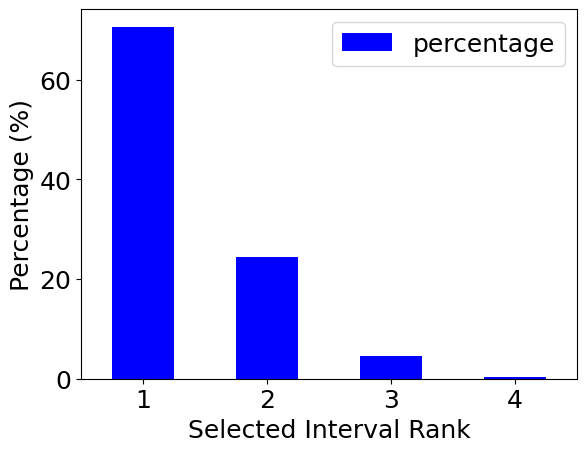

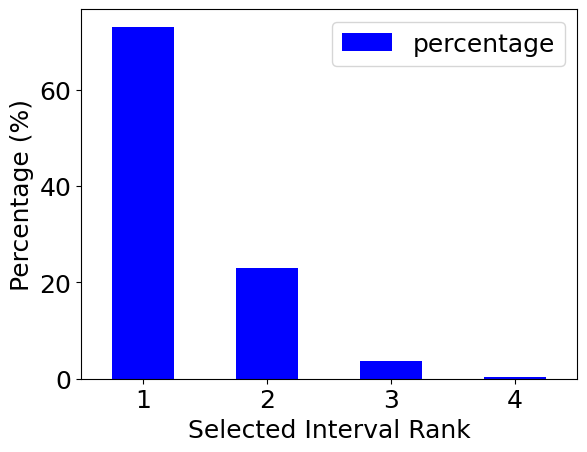

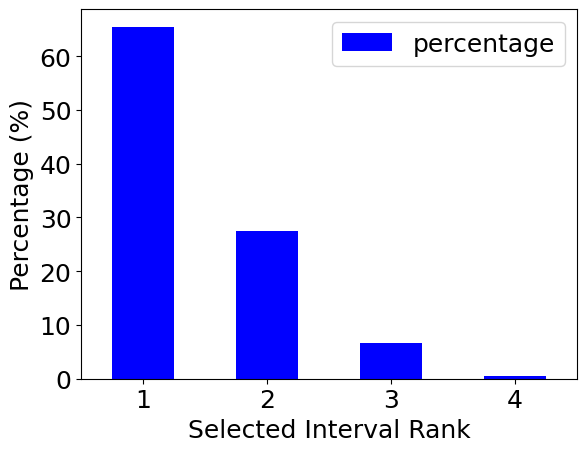

In [ ]:
xx_ranks = analyse_intervals(ref_data = xx, data_name = DATASET, model_name = MODEL_NAME)

In [ ]:
xx_ranks.dropna()

AttributeError: 'NoneType' object has no attribute 'dropna'

In [ ]:
xx_ranks[0].item()

2